# HW 2 Problem 4

Seokjun Choi

*Python is used for this work. Below codes are tested at Python 3.10.15 64-bit in Windows 10.*

*Link for the stand-alone Python script: https://github.com/letsjdosth/StatLearning/blob/main/hw2p4.py*

*(Especially because of the type annotation, Python interpreters lower than version 3.8 may not run this code.)*

## (d) Implementing the shooting algorithm

The function *shooting2* is the core part of the shooting algorithm.
In each iteration of the 'while' statement, each coordinate is updated sequentially (not randomly.)
The variable *xb* is the cached variable for $X\beta = \tilde{X}\tilde{\beta]}$, following the answer of 4-(c).

I tested two other implementations, which are
1. without caching
    - It turns out that caching saves a lot of time. I could not finish the 5-fold CV at nine lambda points even if I ran the code for 2 hours. (So I gave up running.)
2. block-coordinate descent / full-coordinate descent
    - I thought that it should work. However, when $\lambda$ value is small, it severely suffers from a convergence problem with more than one-coordinate descent. Determining a stopping rule is tricky.
    - With high $\lambda$, actually multi-coordinate-descent(?) is faster than one-coordinate-descent. As long as my computer's memory allows it to run, a block coordinate descent is a better option.

I will not include these additional implementations' results in this document.
If you want, please see the stand-alone python script. (you can find two more functions for the shooting algorithm.)

In [11]:
import numpy as np
import matplotlib.pyplot as plt

rv_gen = np.random.default_rng(seed=20221107)

# generating synthetic data
n = 50
p = 1000
Sigma = np.zeros((p,p))
for i in range(Sigma.shape[0]):
    for j in range(Sigma.shape[1]):
        Sigma[i,j] = 0.5**abs(i-j)

x_array = rv_gen.multivariate_normal(np.zeros((p)), Sigma, size=50) #(50, 1000)
beta = np.array([1.5, 0, 0.5, 0, 1] + [0 for _ in range(p-5)])
y_array = x_array @ beta + rv_gen.multivariate_normal(np.zeros((n)), 0.04*np.identity(n)) #(50,)


def average_loss(x: np.array, y: np.array, fitted_beta: np.array):
    n = x.shape[0]
    return sum((y - x@fitted_beta)**2)**0.5 / n

def lasso_loss(x: np.array, y: np.array, lambda_val: int|float, fitted_beta: np.array):
    return average_loss(x,y,fitted_beta) + lambda_val*sum([abs(b) for b in fitted_beta])

def l0_norm(a: np.array):
    return np.count_nonzero(a)


def shooting2(x: np.array, y: np.array, lambda_val: int|float, initial_beta: list, epsilon=1e-5):
    n = x.shape[0]
    p = x.shape[1]
    xb = x@initial_beta

    beta_tilde = np.array([b if b>0 else 0 for b in initial_beta] + [-b if b<0 else 0 for b in initial_beta])
    # print(beta_tilde.shape) #(2000,)

    num_iter = 0
    delta = np.zeros((2*p))
    while(True):
        num_iter += 1
        for j in range(2*p):
            beta_tilde_j = beta_tilde[j]
            if j<p:
                x_tilde_j = x[:,j]
            else:
                x_tilde_j = -x[:,j-p]
            grad = np.transpose(x_tilde_j) @ (xb - y)/n + lambda_val

            delta_j = np.max((-beta_tilde_j, -grad))
            delta[j] = delta_j
            
            new_beta_tilde_j = beta_tilde_j + delta_j
            beta_tilde[j] = new_beta_tilde_j

            xb += (delta_j*x_tilde_j)
            # print(xb)
            
        if sum(delta**2) < epsilon:
            print("iter:", num_iter)
            return beta_tilde[0:p] - beta_tilde[p:2*p]
        if num_iter > 5000:
            print("it may not fit fully. iter:", num_iter)
            return beta_tilde[0:p] - beta_tilde[p:2*p]

**One Sad thing**: I'm using laptop having INTEL 8265U CPU with 8GB RAM. (Yes, 8th gen! You may know that currently, the newest is 13th gen.)
Running 5-fold CV at 21 different $\lambda$ values $(0, 0.01,...,0.20)$ was too harsh work for my computer, making my desk endlessly warm (it was running for more than 3 hours, so again I gave up.)
Alternatively, I run 9 $\lambda$ points $(0, 0.025, ..., 0.175, 0.2)$. Happily, it finished within 2 hours.

To avoid too many loops, I set to cut each while loop at the 5000th iteration.
Luckily, all cases converge within 2800 iterations (Generally, lower $lambda>0$ requires more iterations to converge.)
So we do not need to worry about under-fit.

In [ ]:
initial_beta = [10*rv_gen.random()-0.5 for _ in range(p)]

lambda_candid = np.arange(0, 0.21, 0.025)

l0_norm_vec = []
training_average_quad_loss_vec = []
training_average_lasso_loss_vec = []
testing_average_quad_loss_vec = []
testing_average_lasso_loss_vec = []

for lambda_val in lambda_candid:
    # print("lambda_val:", lambda_val)
    l0_norm_at_lambda = []
    training_quad_loss_at_lambda = []
    training_lasso_loss_at_lambda = []
    testing_quad_loss_at_lambda = []
    testing_lasso_loss_at_lambda = []
    
    for batch_idx in range(5): #5fold-cross-validation
        print("lambda_val:", lambda_val, " batch:", batch_idx)
        test_index = [batch_idx*10+i for i in range(10)]
        train_index = [i for i in range(batch_idx*10)] + [i for i in range(test_index[-1]+1, 50)]

        train_x_array = x_array[train_index,:]
        train_y_array = y_array[train_index]
        test_x_array = x_array[test_index,:]
        test_y_array = y_array[test_index]

        beta_fit = shooting2(train_x_array, train_y_array, lambda_val, initial_beta)
        l0_norm_at_lambda.append(l0_norm(beta_fit))
        training_quad_loss_at_lambda.append(average_loss(train_x_array, train_y_array, beta_fit))
        training_lasso_loss_at_lambda.append(lasso_loss(train_x_array, train_y_array, lambda_val, beta_fit))
        testing_quad_loss_at_lambda.append(average_loss(test_x_array, test_y_array, beta_fit))
        testing_lasso_loss_at_lambda.append(lasso_loss(test_x_array, test_y_array, lambda_val, beta_fit))
    
    l0_norm_vec.append(np.mean(l0_norm_at_lambda))
    training_average_quad_loss_vec.append(np.mean(training_quad_loss_at_lambda))
    training_average_lasso_loss_vec.append(np.mean(training_lasso_loss_at_lambda))
    testing_average_quad_loss_vec.append(np.mean(testing_quad_loss_at_lambda))
    testing_average_lasso_loss_vec.append(np.mean(testing_lasso_loss_at_lambda))

In [13]:
print([(l,ll) for l,ll in zip(lambda_candid, l0_norm_vec)])
# [(0.0, 923.0), (0.025, 32.8), (0.05, 18.4), (0.075, 13.0), (0.1, 7.8), (0.125, 5.6), (0.15, 4.8), (0.175, 4.0), (0.2, 3.8)]

[(0.0, 923.0), (0.025, 32.8), (0.05, 18.4), (0.07500000000000001, 13.0), (0.1, 7.8), (0.125, 5.6), (0.15000000000000002, 4.8), (0.17500000000000002, 4.0), (0.2, 3.8)]


The above outputs are $(\lambda,||\beta||_{0})$ pairs.
As pointed out in the lecture, LASSO cannot give non-zero elements more than $max(n,p)$.
(But when failing to converge, particularly when $\lambda$ is very close to 0, the algorithm gives an estimate with too many non-zeros, more than $n$.)

Note that the true $\beta$'s $l_0$ norm is 3.

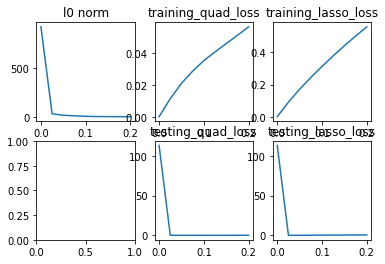

In [14]:
fig, ax = plt.subplots(2,3)
ax[0,0].plot(lambda_candid, l0_norm_vec)
ax[0,0].set_title("l0 norm")
ax[0,1].plot(lambda_candid, training_average_quad_loss_vec)
ax[0,1].set_title("training_quad_loss")
ax[0,2].plot(lambda_candid, training_average_lasso_loss_vec)
ax[0,2].set_title("training_lasso_loss")

ax[1,1].plot(lambda_candid, testing_average_quad_loss_vec)
ax[1,1].set_title("testing_quad_loss")
ax[1,2].plot(lambda_candid, testing_average_lasso_loss_vec)
ax[1,2].set_title("testing_lasso_loss")
plt.show()

Five graphs (below-left is a blank) show the $l_0$-norms(the number of non-zero elements in each estimate, which are the same information on the above block), training/testing quadratic losses, training/testing lasso losses(objective function value) for nine lambda values.

If I did not know the true $\beta$, I might have chosen $lambda$ around 0.175, where the $l_0$ norm's rate of decline starts to slow down markedly.
I could get the estimate with four non-zero elements.

Note that choosing $\lambda$ using quadratic training loss is nonsense.
LASSO yields a biased estimator whose bias grows with large $\lambda$, so I think this criterion leads to too small $\lambda$.
It can be viewed as a case of overfitting.

One may argue that $\lambda$ that makes testing quadratic loss minimum is the best choice.
I know that many people are widely accepting this rule.
If our goal is only prediction, I agree with the argument. I should choose larger $\lambda$.

However, balancing bias and sparsity may be important if we consider the inference about $\beta$ itself.
But, it may be fair to say that doing inference on $\beta$ using LASSO is not a very good idea, though.